In [19]:
#%matplotlib notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import csv

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import chi2

import os
import os.path as path
import wget

In [3]:
if not path.exists('Data'):
    os.mkdir('Data')
    
!rm Data/*

file = 'Data/Minimos.dat'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

"rm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


File loaded


In [20]:
csv_file = 'Rhodium.csv'

x_data = []
y_data = []

with open(csv_file, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader) 
    for row in spamreader:
        x_data.append(float(row[0]))
        y_data.append(float(row[1]))

x = np.array(x_data)
y = np.array(y_data)


In [21]:
def filtrar_por_ventanas(x, y, ventana=5, umbral=5):
    x_limpio = []
    y_limpio = []
    
    for i in range(len(y)):
        inicio = max(0, i - ventana)
        fin = min(len(y), i + ventana + 1)
        
        ventana_y = y[inicio:fin]
        
        mediana = np.median(ventana_y)
        mad = np.median(np.abs(ventana_y - mediana))
        if mad == 0:
            mad = 1e-6  
        
        robust_z = np.abs((y[i] - mediana) / (mad * 1.4826))
        
        if robust_z <= umbral:
            x_limpio.append(x[i])
            y_limpio.append(y[i])
    
    return np.array(x_limpio), np.array(y_limpio)

In [60]:
def derivative(codom):
    derlist = np.array([])
    for i in range(codom.shape[0]-1):
        der = (codom[i+1] - codom[i])
        np.append(derlist,der)
        
    return derlist

x_limpio, y_limpio = filtrar_por_ventanas(x, y, ventana=6, umbral=3.)

derlista = derivative(y_limpio)

newder = np.array([])
newint = np.array([])
WavelenghtNN = np.array([])
for i in range(derlista.shape[0]):
    if abs(derlista[i]) <= 0.008 and y_limpio[i] <= 0.115:
        np.append(newder,derlista[i])
        np.append(newint,y_limpio)
        np.append(WavelenghtNN,x_limpio[i])

print(newder)

[]


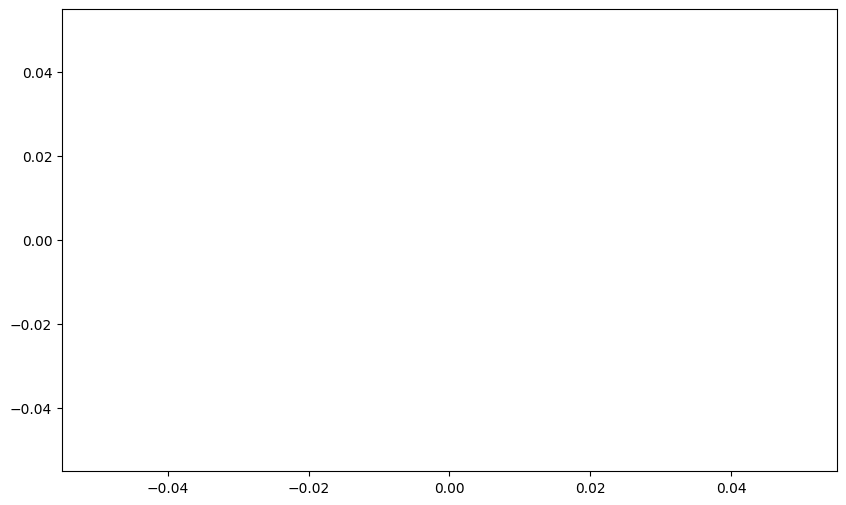

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(WavelenghtNN,newint)
plt.scatter(WavelenghtNN, newder, color='m', label='Pendientes')
plt.show()

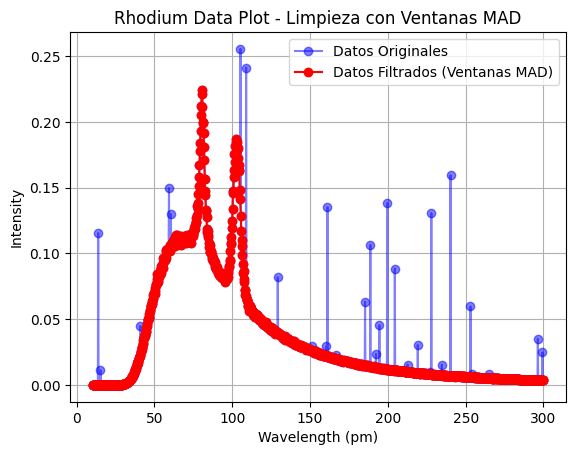

In [53]:
plt.plot(x, y, 'o-', color='b', alpha=0.5, label='Datos Originales')
plt.plot(x_limpio, y_limpio, 'o-', color='r', label='Datos Filtrados (Ventanas MAD)')
plt.xlabel('Wavelength (pm)')
plt.ylabel('Intensity')
plt.title('Rhodium Data Plot - Limpieza con Ventanas MAD')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
data = np.loadtxt(Path_)
x = data[:,0]
y = data[:,1]

In [5]:
# Agregamos ruido
N = len(x)
sigma = np.random.uniform(0,5.,size=N)
sigma

array([2.65859897, 1.971     , 3.81915884, 3.34108719, 4.65058709,
       4.57506495, 3.62672055, 4.01097332, 1.98662474, 0.93233473,
       4.15269457, 4.24443723, 0.68912542, 4.06340721, 2.05267261,
       2.80694201, 0.98124173, 0.33071224, 0.29741156, 2.38998644])

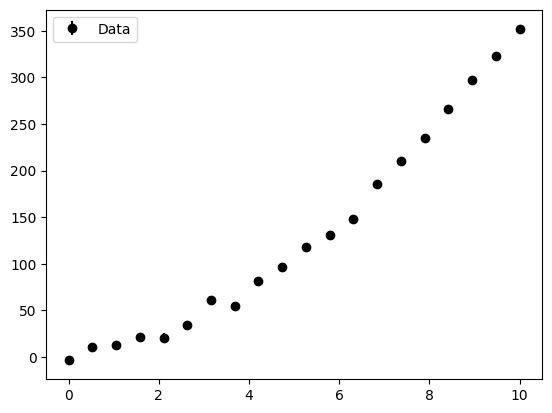

In [6]:
#plt.scatter(x,y)
plt.errorbar(x,y,yerr=sigma,fmt='o',color='k',label='Data')
plt.legend(loc=0)

In [7]:
def GetFit(x,y,n=1):
    
    l = x.shape[0]
    b = y
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    AT = np.dot(A.T,A)
    bT = np.dot(A.T,b)

    xsol = np.linalg.solve(AT,bT)
    
    return xsol

In [8]:
# Grado polinomial
n = 1
param = GetFit(x,y,n)
param

array([-45.46163845,  35.6566259 ])

In [9]:
def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
        
    return y

In [10]:
X = sym.Symbol('x',real=True)
#GetModel(X,param)

In [11]:
_x = np.linspace(np.min(x),np.max(x),50)
_y = GetModel(_x,param)

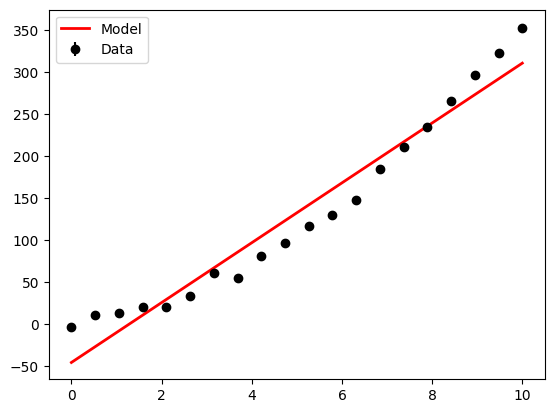

In [12]:
plt.errorbar(x,y,yerr=sigma,fmt='o',color='k',label='Data')
plt.plot(_x,_y,color='r',lw=2,label='Model')
plt.legend()

In [13]:
def GetError(x,y,p):
    
    l = x.shape[0]
    
    A = np.ones((l,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**i
        
    # Residuos
    R = y - np.dot(A,p)
    
    sigma2 = np.dot(R.T,R)/(len(y)-len(p))
    
    Cov = sigma2*np.linalg.inv(np.dot(A.T,A))
    
    #print(sigma2)
    
    return Cov,sigma2

In [14]:
Cov,_ = GetError(x,y,param)
Cov

array([[127.2078106 , -18.59191095],
       [-18.59191095,   3.7183822 ]])

In [44]:
for n in range(10):
    
    param = GetFit(WavelenghtNN,newint,n)
    Cov,_ = GetError(WavelenghtNN,newint,param)
    
    _x = np.linspace(np.min(WavelenghtNN),np.max(WavelenghtNN),10)
    _y = GetModel(_x,param)
    
    ai = param[-1]
    sigmaai = np.sqrt(Cov[-1,-1])
    
    tobs = np.abs(0. - ai)/sigmaai
    
    df = N - len(param) - 1
    #print(df)
    
    tcritico = t.ppf(0.975,df=df)
    tcritico

    print(ai,sigmaai,tobs,tcritico)
    
    fig = plt.figure(figsize=(7,3))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    
    ax.errorbar(WavelenghtNN,newint,fmt='o',color='k',label='Data')
    ax.plot(_x,_y,color='r',lw=2,label='Model polinomial orden {}'.format(n))
    ax.legend()
    
    _t = np.linspace(t.ppf(0.001,df=df),t.ppf(0.999,df=df),100)
    ax1.plot(_t,t.pdf(_t,df=df))
    ax1.axvline(x=tobs,color='k')
    ax1.axvline(x=tcritico,color='r')
    
    #print(param,Cov)

AttributeError: 'list' object has no attribute 'shape'

In [16]:
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'sklearn'

In [18]:
X = x.reshape(-1,1) 
X.shape

(20, 1)

In [62]:
model = LinearRegression() 

In [63]:
reg = model.fit(X,y)

In [64]:
print(reg.intercept_,reg.coef_)

-5.129185528852986 [2.12503681]


In [65]:
param = GetFit(x,y,1)
param

array([-5.12918553,  2.12503681])

In [66]:
reg.score(X,y)

0.9931735511758472

In [68]:
Ypredict = model.predict(X)
#Ypredict

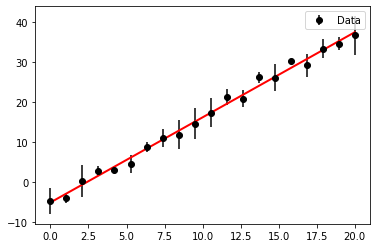

In [70]:
plt.errorbar(x,y,yerr=sigma,fmt='o',color='k',label='Data')
plt.plot(X,Ypredict,color='r',lw=2)
plt.legend(loc=0)